## Chapter 4
I skipped most exercises in this chapter, I use these types of models enough in my work that I don't need to practice them here.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr
 

### Exercise 5

See the accompanying code model_t2 (and the data associated with it). Experiment with priors for $\nu$, like the non-shifted Exponential and Gamma priors (they are commented on in the code). Plot the prior distribution to ensure that you understand them. An easy way to do this is to call the pm.sample_prior_predictive() function instead of pm.sample(). You can also use PreliZ.

Idea is to experiment with the prior on $\nu$, the t distribution degrees of freedom paramenter.   

In [96]:
ans = pd.read_csv('../code/data/anscombe.csv')

x_4 = ans[ans.group == 'IV']['x'].values
y_4 = ans[ans.group == 'IV']['y'].values

with pm.Model(coords_mutable={"obs": range(len(x_4))}) as model_t2:
    x = pm.MutableData('x', x_4, dims = "obs")
    y = pm.MutableData('y', y_4, dims = "obs")
    α = pm.Normal('α', mu=0, sigma=100)
    β = pm.Normal('β', mu=0, sigma=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    #ν = pm.Gamma('ν', mu=20, sigma=15)
    #ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x, sigma=ϵ, nu=ν, observed=y, dims = "obs")
    idata_t2 = pm.sample(target_accept = 0.9, draws = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [97]:
az.summary(idata_t2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,3.026,1.432,0.436,5.908,0.039,0.028,1437.0,1179.0,1.01
β,0.497,0.150,0.199,0.776,0.004,0.003,1432.0,1366.0,1.01
ϵ,1.412,0.438,0.743,2.178,0.011,0.008,1924.0,1689.0,1.00
ν,34.801,30.757,0.953,86.426,0.607,0.445,2335.0,1934.0,1.00


Note that you *can* use `pm.sample_prior_predictive` or `preliz` here, but I like to just directly take draws from the prior variable. It seems more straightforward.

<Axes: >

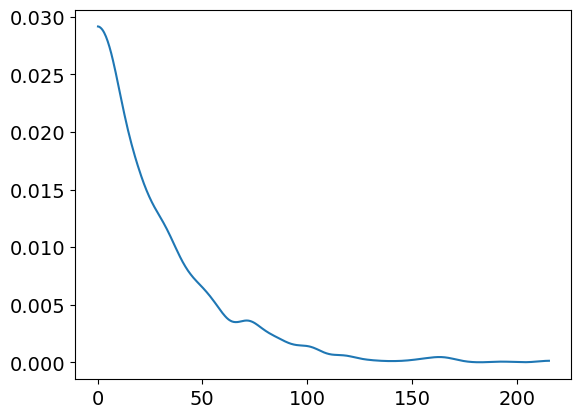

In [48]:
az.plot_dist(pm.draw(ν, draws = 1000))

In [101]:
def plot_model(idata,model):
    idata = pm.sample_posterior_predictive(idata,  model=model, extend_inferencedata=True)
    idata.posterior["y_model"] = idata.posterior["α"] + idata.posterior["β"]*xr.DataArray(x_4 )
    az.plot_lm(idata = idata, x='x',y='y_pred' ,y_hat = 'y_pred',y_model='y_model', kind_model = "hdi", kind_pp = "samples")
    # move legend off plot to right  
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Sampling: [y_pred]


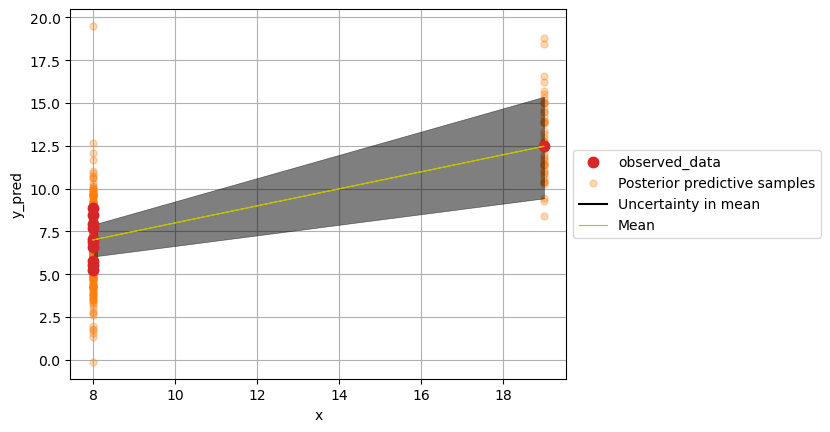

In [102]:
plot_model(idata_t2,model_t2)

In [103]:
with pm.Model(coords_mutable={"obs": range(len(x_4))}) as model_t2b:
    x = pm.MutableData('x', x_4, dims = "obs")
    y = pm.MutableData('y', y_4, dims = "obs")
    α = pm.Normal('α', mu=0, sigma=100)
    β = pm.Normal('β', mu=0, sigma=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    #ν = pm.Exponential('ν', 1/30)
    ν = pm.Gamma('ν', mu=20, sigma=15)
    #ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x, sigma=ϵ, nu=ν, observed=y, dims = "obs")
    idata_t2b = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ, ν]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


In [104]:
az.summary(idata_t2b)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,3.102,1.410,0.479,5.928,0.025,0.018,3422.0,3192.0,1.0
β,0.488,0.148,0.183,0.758,0.003,0.002,3458.0,3692.0,1.0
ϵ,1.408,0.416,0.779,2.200,0.007,0.005,3095.0,2410.0,1.0
ν,22.158,14.905,1.971,49.471,0.226,0.160,3997.0,4042.0,1.0


This prior change muhc, perhaps moved nu down, but nu already is quite large 

<Axes: >

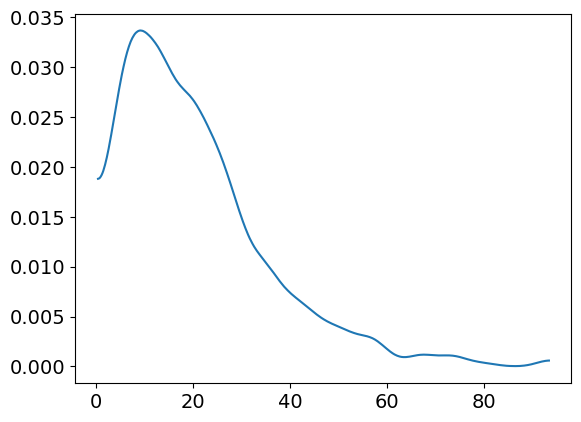

In [105]:
az.plot_dist(pm.draw(ν, draws = 1000))

Sampling: [y_pred]


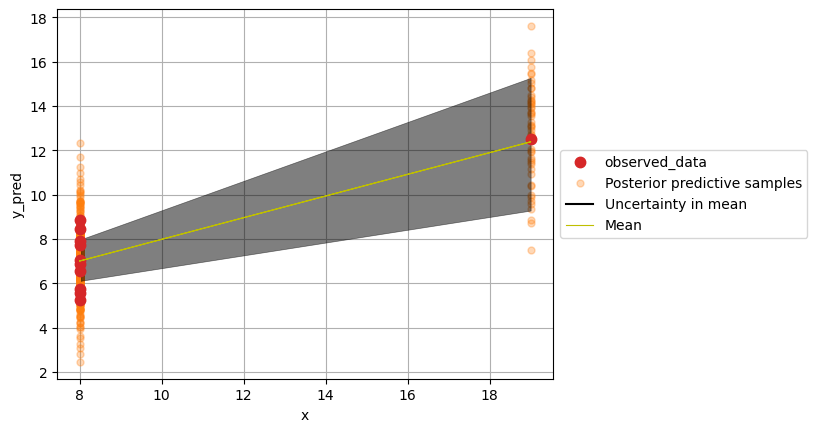

In [106]:
plot_model(idata_t2b,model_t2b)

I am not sure this is the correct data set intended for this problem, as the student-t is not really required here (we are getting large $\nu$) Perhaps the problem meant to use quartet member III ?

NOte that the final example Gamma(2,.1)  has mean 20 and variance 2/(.1)^2 = 200 (sd =14 ) so is basically the same thing.  The default parameters for gamma are $\alpha$ and $\beta$. See docs

<Axes: >

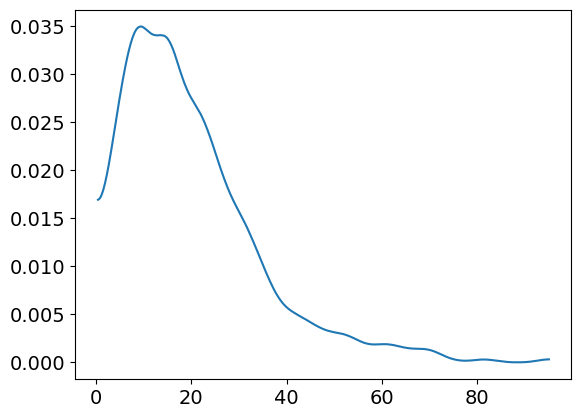

In [65]:
az.plot_dist(pm.draw(pm.Gamma.dist(2,0.1), draws = 1000))